# 07wk-2: (합성곱신경망) XXX

최규빈  
2025-01-01

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/05wk-2
    .ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [13]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wcPiCEdYML9-6-Xv5RVbso&si=BbNo6mwCHqwOV0FS>}}

# 2. Imports

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. CNN 핵심레이어

## A. `torch.nn.ReLU`

## B. `torch.nn.MaxPool2d`

## C. `torch.nn.Conv2d`

**(예시1) 연산방법, stride=2**

In [4]:
img = torch.rand(1,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2)

In [5]:
img

In [6]:
conv(img)

??

In [7]:
conv.weight.data, conv.bias.data

In [8]:
(img[:,  :,  :2,  :2] * conv.weight.data).sum()+conv.bias.data, conv(img)

In [9]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

In [10]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

In [11]:
(img[:,  :,  2:,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

> **Note**
>
> **입력이 1장의 흑백이미지이고 출력도 1장의 흑백이미지일 경우 컨볼루션
> 계산과정 요약[1]**
>
> 1.  윈도우생성: `kernel_size` = (?,?) 인 윈도우를 만듦
> 2.  sub-img생성: 입력 이미지에 윈도우를 통과시켜 (?,?) 크기의
>     sub-img를 만듦.
> 3.  연산: sub-img의 각 원소에 `conv.weight`의 값을 원소별로
>     (=element-wisely) 곱하고 결과를 더함. (만약에 `conv.bias`가 있다면
>     최종결과에 bias를 더함)
> 4.  이동&반복: 윈도우를 `stride` 만큼 이동하여 반복. (`stride`=1
>     이라면 한칸씩, `stride`=2 라면 두칸씩 이동)

**(예시2)** – 재현

“A guide to convolution arithmetic for deep learning” (Dumoulin and
Visin 2016) 에 나온 그림재현

-   ref: <https://arxiv.org/abs/1603.07285>

<figure class="margin-caption">
<img
src="https://github.com/guebin/2021BDA/blob/master/_notebooks/2021-11-04-conv.png?raw=true"
alt="Fig: conv2d 계산과정시각화" />
<figcaption aria-hidden="true">Fig: conv2d 계산과정시각화</figcaption>
</figure>

**(예시3) 이동평균**

**(예시4) 2개의 이미지**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 observation 별로 적용

-   `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우와
    (n,1,?,?) $\to$ (n,1,?,?)인 경우가 동일

**(예시5) 2개의 out_channels**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 하나의 채널에 적용, 그리고
또 다른 채널에는 (1,1,?,?) $\to$ (1,1,?,?) 인 다른 conv를 적용함.

-   `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우보다
    (1,1,?,?) $\to$ (1,2,?,?)인 경우가 2배 많음[2]

# 4. CNN의 학습원리

## A. data

아래의 4개의 이미지를 생각하자 .

## B. 세로엣지

## C. 가로엣지

## D. 이동평균

## E. (C,D,E) + relu + mp

## F. 대충 이런 구조

## G. mp의 역할? – 선택

`-` 샘플이미지

[1] 입력shape=(1,1,?,?) 이고 출력의shape=(1,1,?,?)일 경우

[2] bias가 있어도 2배임

In [859]:
img = torch.zeros((1, 1, 16, 16))
triangle_size = 4
for i in range(triangle_size):
    for j in range(triangle_size):
        if j <= i:  # 아래 방향 직각삼각형 (왼쪽 위 꼭짓점 기준)
            img[0, 0, i, j] = 1.0

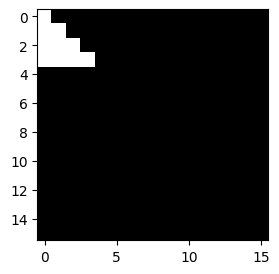

In [868]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp1 회

`-` mp 2~4회

`-` maxpooling은 이미지를 “캐리커처화” 한다고 비유할 수 있음. 디테일은
버리고, 중요한 특징만 뽑아서 과장되게 요약한다.

# 5. FashionMNIST

`-` 데이터

In [941]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset]).to("cuda:0")
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float().to("cuda:0")

`-` 2d를 처리하고 flatten하는 네트워크

`-` 1d를 처리하는 네트워크

`-` 두 네트워크를 결합

`-` 최종적인 코드

Dumoulin, Vincent, and Francesco Visin. 2016. “A Guide to Convolution
Arithmetic for Deep Learning.” *arXiv Preprint arXiv:1603.07285*.